# QC Notebook
## This notebook is an example: create a copy before running it or you will get merge conflicts!
This notebook can be run to compute and visualize the QC metrics for the run.

In [ ]:
import sys
sys.path.append('../')

In [ ]:
from datetime import datetime as dt
import os
import re
import pandas as pd
import natsort as ns

from mibi_bin_tools import bin_files
from toffy import qc_comp
from ark.utils import io_utils

### Define file parameters

- `run_name` should contain the exact name of the MIBI run to extract qc data from 
- `panel_path` should point to a panel csv specifying the targets on your panel. For an example, see the [example panel file](https://github.com/angelolab/toffy/blob/main/files/example_panel_file.csv)

In [ ]:
# the name of the run
run_name = 'YYYY-MM-DD_run_name'

# path to user panel
panel_path = 'C:\\Users\\Customer.ION\\Documents\\panel_files\\my_cool_panel.csv'

# path where plots will get saved
bin_file_path = os.path.join('D:\\Data', run_name)
qc_out_dir = os.path.join('C:\\Users\\Customer.ION\\Documents\\run_metrics', run_name)

# make qc_dir if it doesn't exist
if not os.path.exists(qc_out_dir):
    os.mkdir(qc_out_dir)

### Create QC metric tables

Channels in an image may contain differing levels of noise. If this is not addressed, it can lead to anomalous QC results that may be the result of artifacts in the image, and not an actual problem with extraction. Significant noise needs to be corrected for prior to QC generation by using Gaussian blurring, which smooths out the signal preventing noisy artifacts from affecting the final result.

Smoothing is done by defining, for each pixel separately, a Gaussian kernel with it as the center. The kernel is used to weight the surrounding pixels, which are then averaged to define the new value of the pixel in question.

* `gaussian_blur`: set to `True` if a Gaussian blur is desired
* `blur_factor`: define the standard deviation of the Gaussian kernel. Use a higher value to widen the Gaussian kernel, which further flattens the weights assigned to the surrounding pixels and results in more aggressive smoothing. Ignored if `gaussian_blur` is `False`.

In [8]:
gaussian_blur = True
blur_factor = 1

In [ ]:
# retrieve all the fov names from bin_file_path
fovs = io_utils.remove_file_extensions(io_utils.list_files(bin_file_path, substrs='.bin'))

# run QC metric extraction on each fov that doesn't have QC metric files defined
# saves directly to bin_file_path
for fov in ns.natsorted(fovs):
    # NOTE: if nonzero_mean_stats.csv doesn't exist, the other QC metric .csv paths also don't exist
    if not os.path.exists(os.path.join(bin_file_path, '%s_nonzero_mean_stats.csv' % fov)):
        print("Extracting QC metrics for fov %s" % fov)
        qc_comp.compute_qc_metrics(
            bin_file_path,
            fov,
            panel_path,
            gaussian_blur=gaussian_blur,
            blur_factor=blur_factor
        )

### Visualize QC metrics

In [7]:
# prior to generating the graphs, need to combine the QC metrics for each FOV into one combined .csv
qc_comp.combine_qc_metrics(bin_file_path)

For QC metric analysis, nonzero mean tends to be the most useful for most users. This is because it gives a high-level overview of the overall distribution of pixel values for each channel while ignoring out regions where the channel does not exist. You can use this to determine if certain channels experienced significantly higher or lower expressions across the cohort compared to other channels. It can also be used to isolate peaks where particular FOVs demonstrated a higher or lower than usual expression value for a particular channel.

The nonzero mean for each channel is presented in FOV acquisition order (values on the left represent FOVs extracted earlier, and vice versa for values on the right). You may notice the values decreasing for FOVs acquired later. This is fine as long as the this is happening monotonically.

<div>
    <img src="img/qc_drift_good.png" width="300" height="274"/>
</div>

However, non-linear decreasing patterns for a particular channel should not be expected. This could indicate a problem with the commercial instrument itself or the extraction parameters used.

<div>
    <img src="img/qc_drift_bad.png" width="300" height="274"/>
</div>

Similar principles can be used to analyze total intensity and 99.9% intensity values.

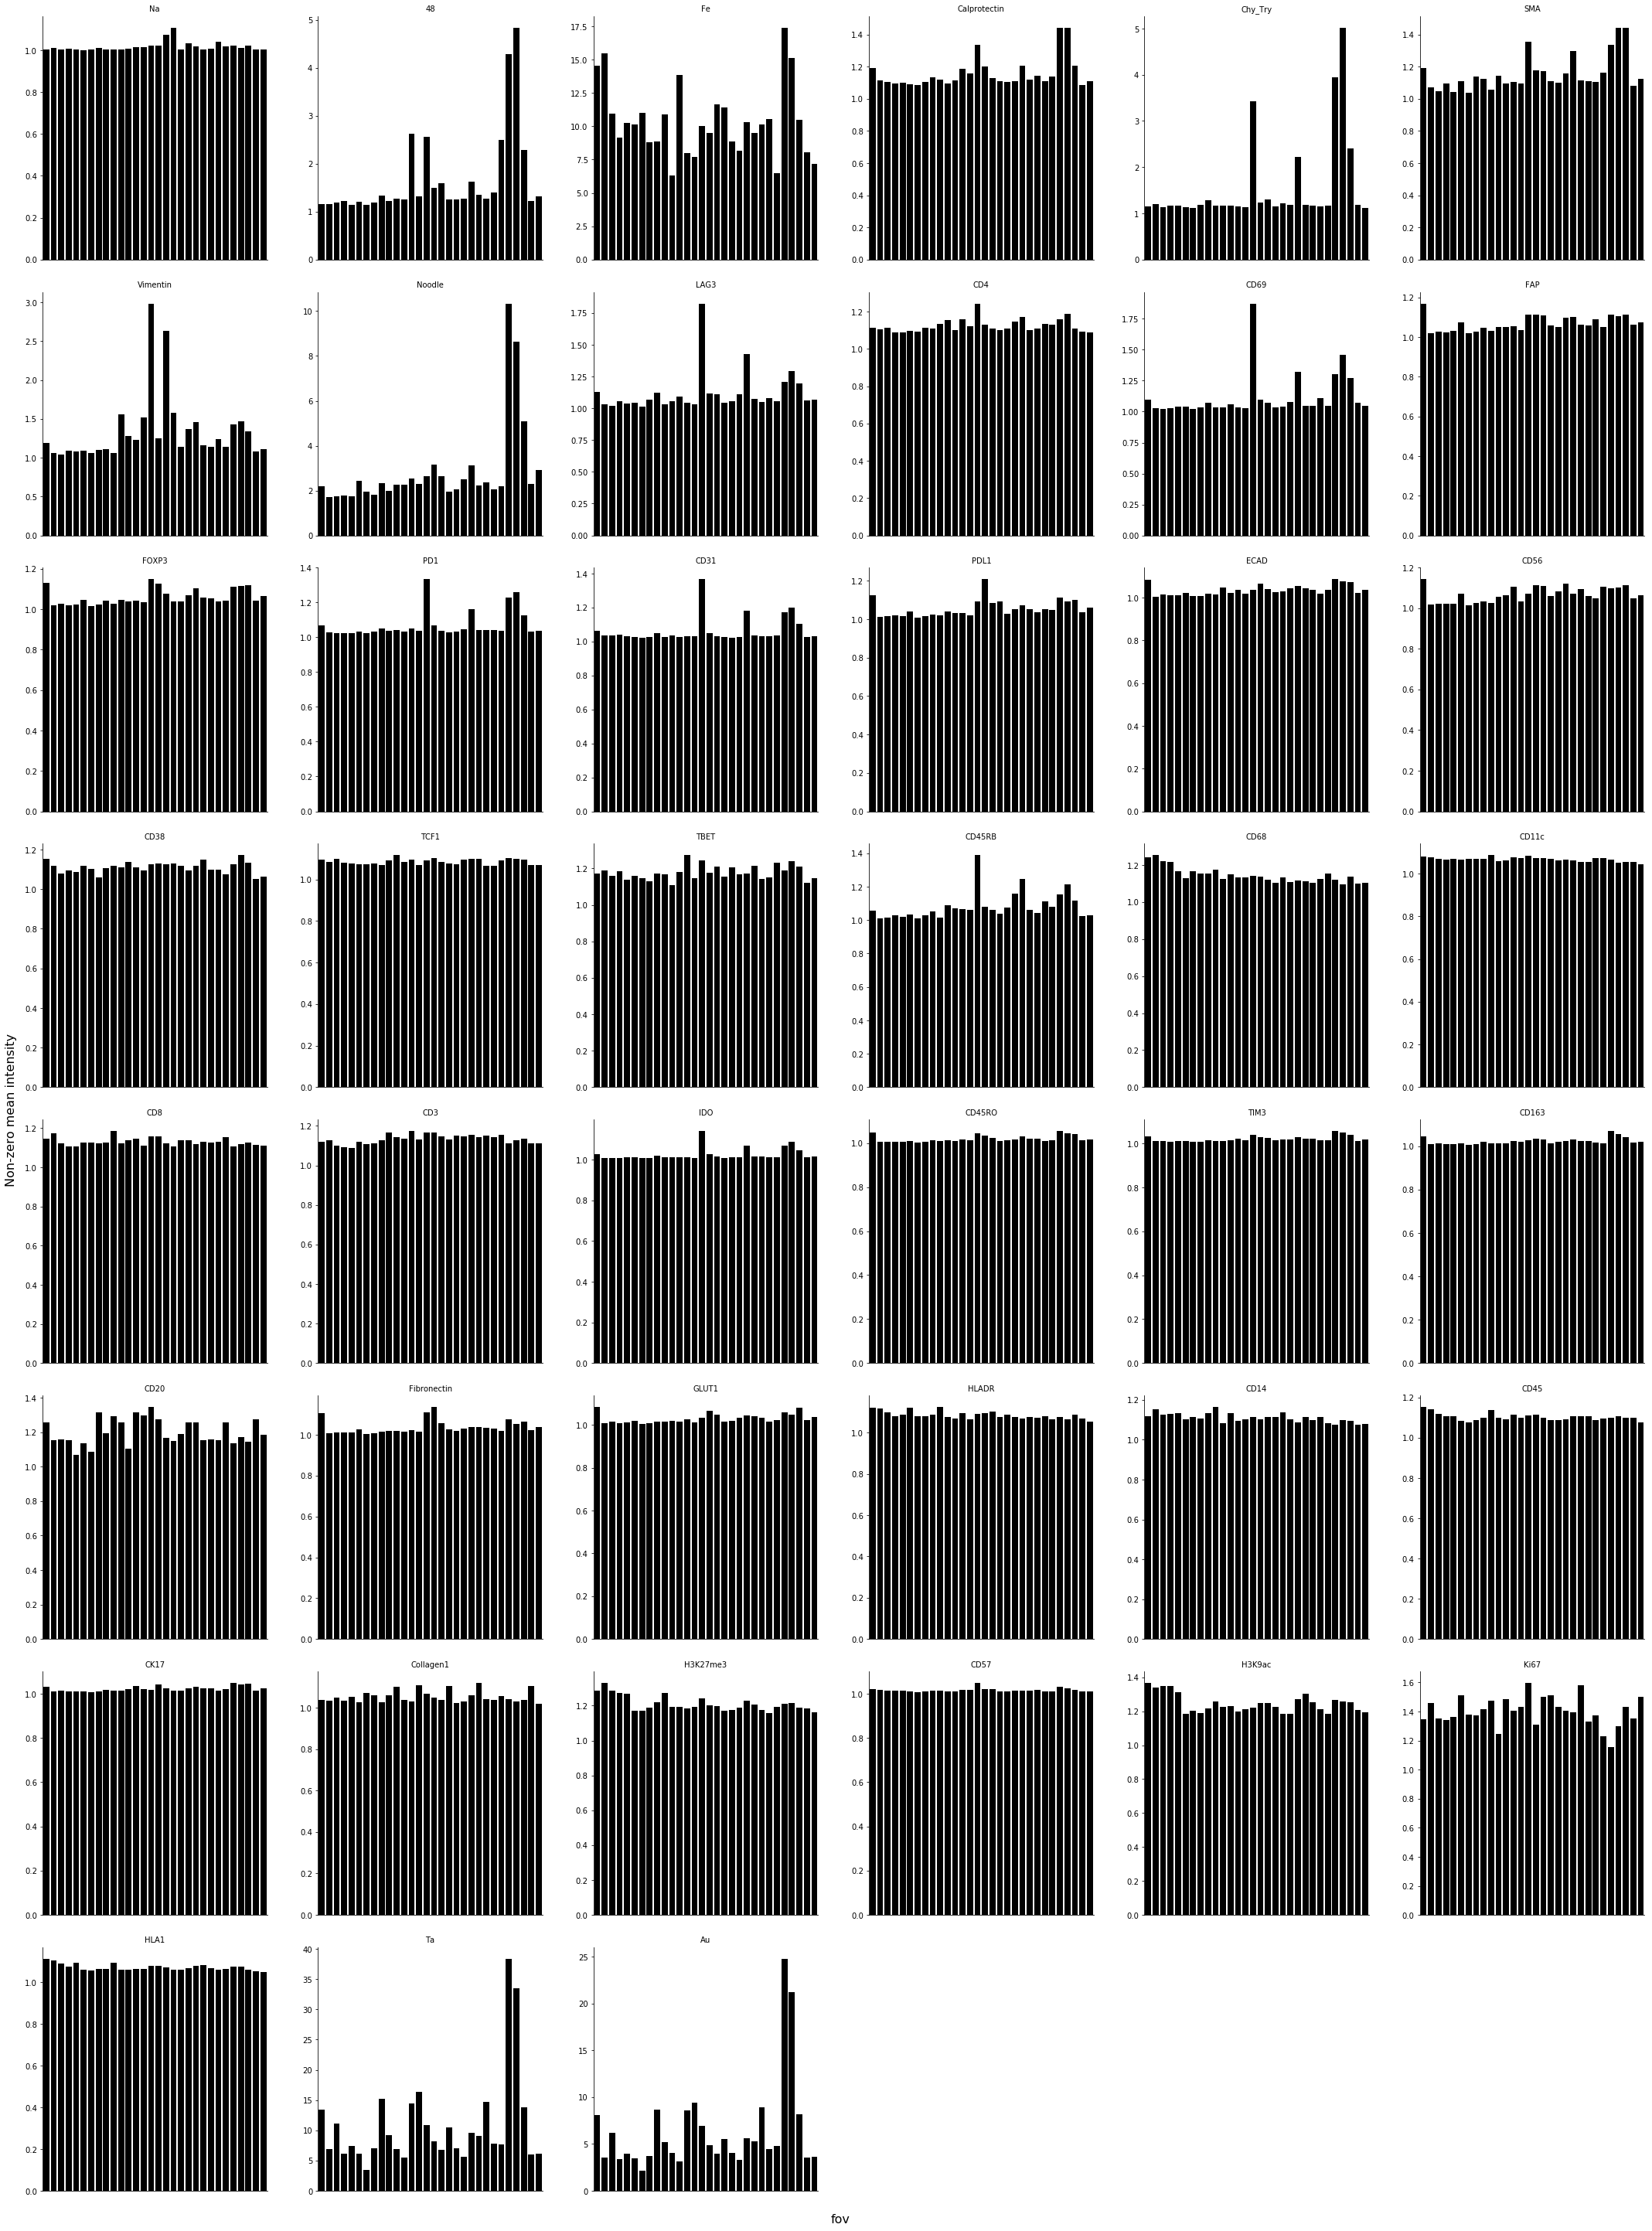

In [11]:
# visualize the non-zero mean intensity stats
df_nonzero_mean = pd.read_csv(os.path.join(bin_file_path, 'combined_nonzero_mean_stats.csv'))

qc_comp.visualize_qc_metrics(
    df_nonzero_mean,
    'Non-zero mean intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=qc_out_dir
)

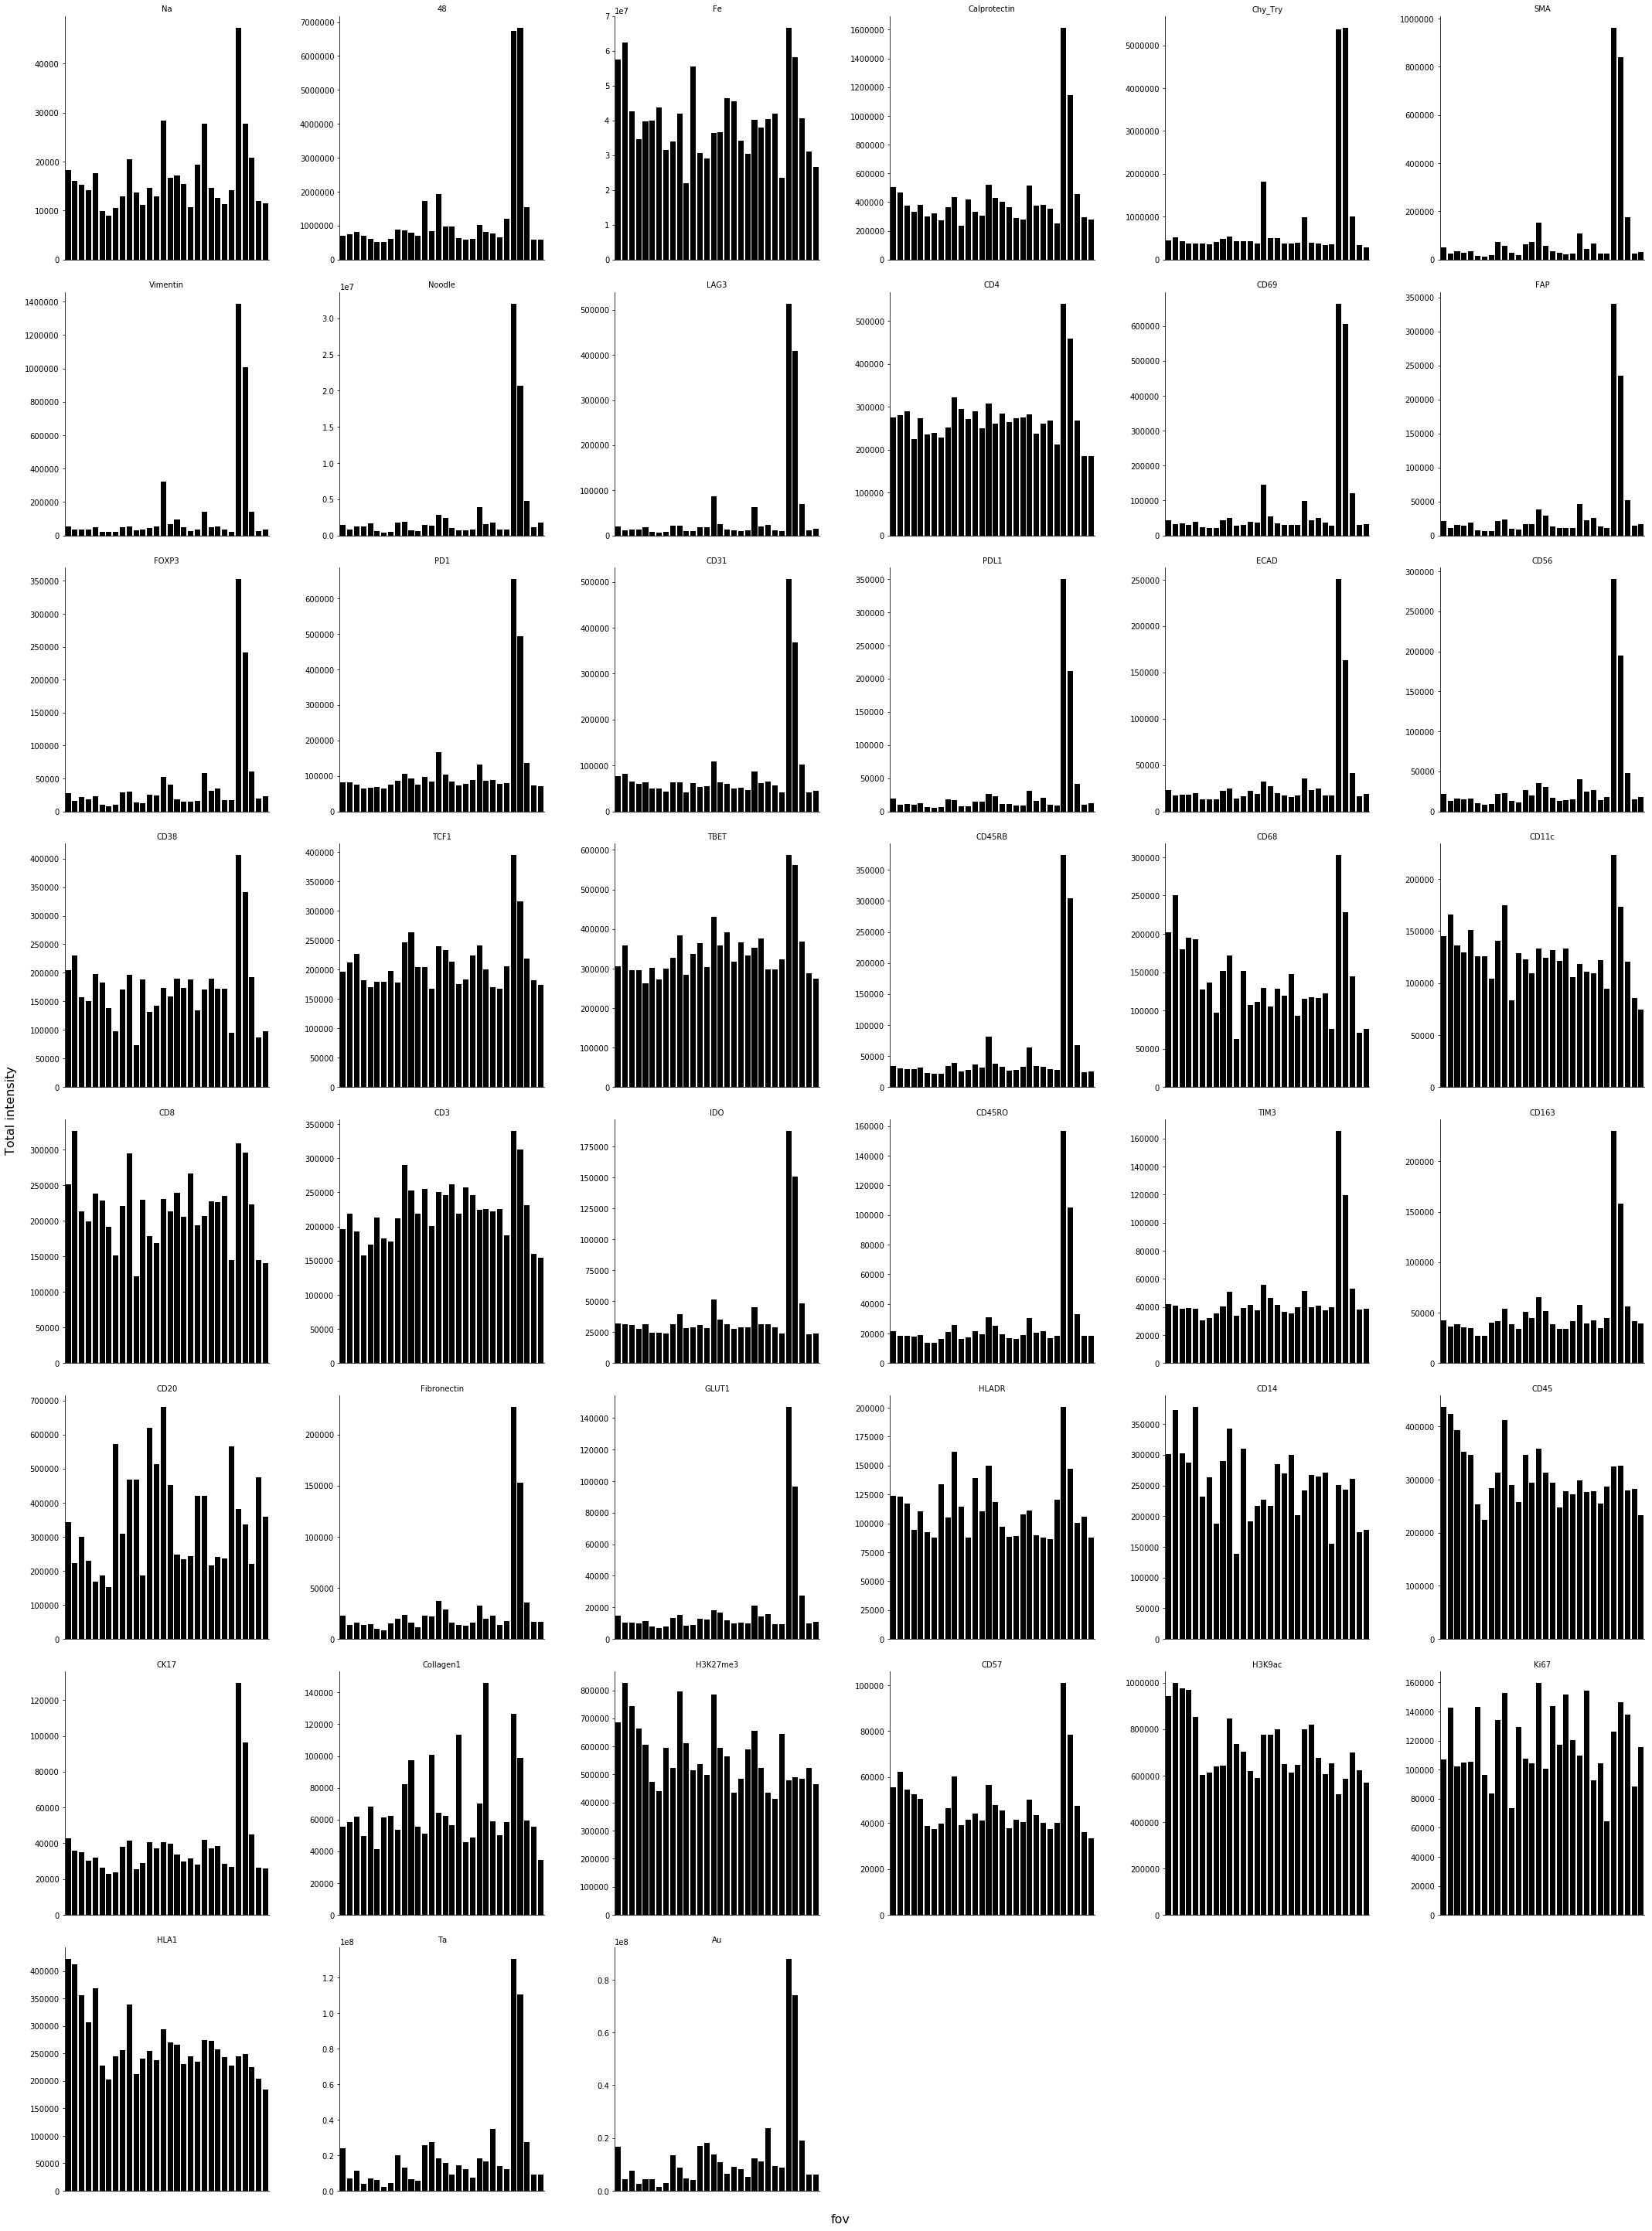

In [13]:
# visualize the total intensity stats
df_total_intensity = pd.read_csv(os.path.join(bin_file_path, 'combined_total_intensity_stats.csv'))

qc_comp.visualize_qc_metrics(
    df_total_intensity,
    'Total intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=qc_out_dir
)

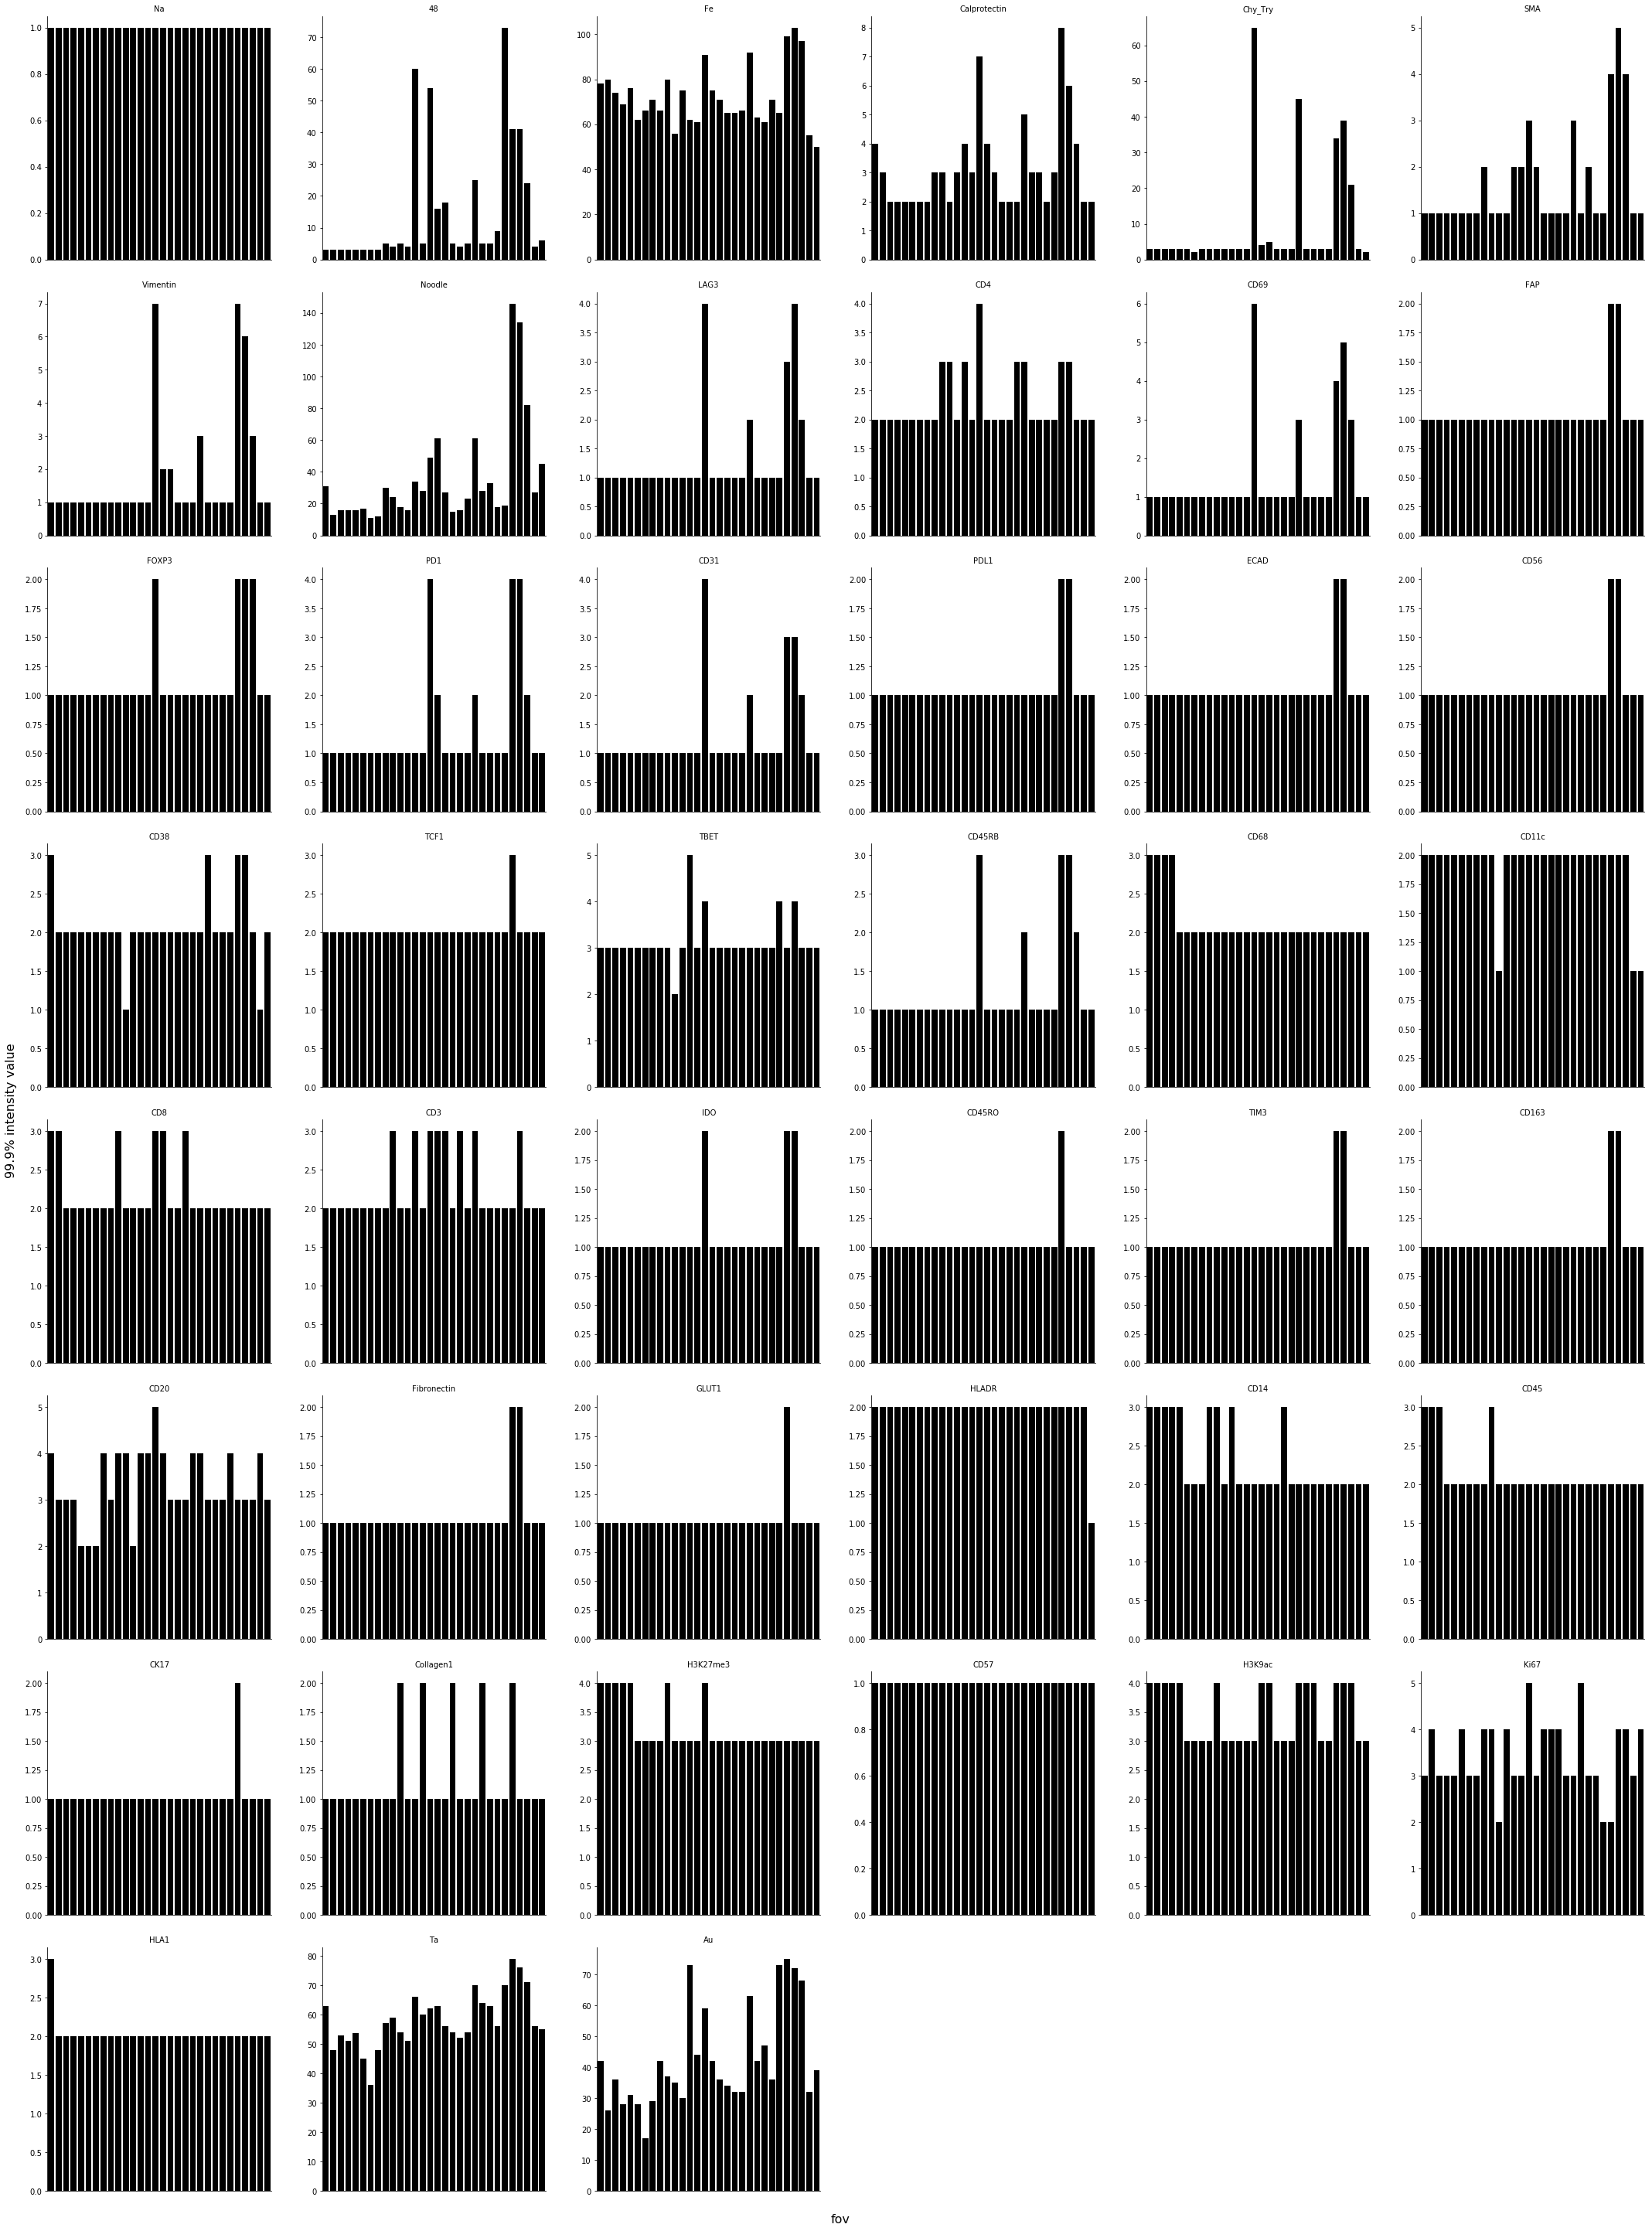

In [14]:
# visualize the 99.9% intensity value stats
df_99_9_intensity = pd.read_csv(os.path.join(bin_file_path, 'combined_percentile_99_9_stats.csv'))

qc_comp.visualize_qc_metrics(
    df_99_9_intensity,
    '99.9% intensity value',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=qc_out_dir
)